# Fine-tuning SmolVLM with GRPO and SFT for improve object understanding

## Load Libs

In [54]:
import datasets
import torch
from PIL import Image
from transformers.image_utils import load_image
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics3ForConditionalGeneration, AutoModelForVision2Seq, TrainingArguments, Trainer
import json
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
from trl import GRPOTrainer, GRPOConfig

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import wandb
from datasets import load_dataset

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
import gc

model = None
processor = None

In [55]:
def clear_model_data(model, processor):
    try:
        del model
        print("delete model")
    except:
        pass
    try:
        del processor  
        print("delete processor")
    except:
        pass

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [56]:
def display_confusion_matrix_FL(data, P = "Positive Class", N = "Negative Class", question = None, positive_mark = None, targets = None):
    assert targets != None, "Pleaset, give the targets (true labels list). The labels should be the same, as the positive class and the negative class"
    assert question != None, "Please, give the question name. example: data[...][question] == answer for your question"
    assert positive_mark != None, "Please, give positive mark. example: question - There is a sting that can be used to divide answers into positive and negative classes (There is a carrot on the plate? - positive_mark == yes)"
    
    preds = []

    for _, item in data.items():
        preds.append(P if item["last_iter_QA"][question].lower().find(positive_mark) != -1 else N)
        preds.append(P if item["first_iter_QA"][question].lower().find(positive_mark) != -1 else N)

    cm = confusion_matrix(targets, preds, labels=[P, N])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[P, N])

    disp.plot()

def display_confusion_matrix_general(data, P = "Positive Class", N = "Negative Class", question = None, gt_answer = None, positive_mark = None):
    assert question != None, "Please, give the question name. example: data[...][question] == answer for your question"
    assert positive_mark != None, "Please, give positive mark. example: question - There is a sting that can be used to divide answers into positive and negative classes (There is a carrot on the plate? - positive_mark == yes)"
    assert gt_answer != None, "Please, give the ground - true answers for question from data, for ex: src_on_target"

    preds = []
    targets = []

    for _, item in data.items():
        for i in range(len(item)):
            preds.append(P if item[f"{i}_frame"]["QA"][question].lower().find(positive_mark) != -1 else N)
            targets.append(P if item[f"{i}_frame"]["data"][gt_answer] else N)
        

    cm = confusion_matrix(targets, preds, labels=[P, N])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[P, N])

    disp.plot()

In [57]:
def load_data_from_npz(path = None, num_of_samples = None):
    '''Parce episode data files, extract only first, mid and end data'''
    if path is None:
        raise ValueError("You're not send path")
    
    npz_files = [f for f in os.listdir(path) if f.find('.npz') != -1]

    if num_of_samples != None:
        npz_files = npz_files[0:num_of_samples]

    files = {}
    
    for file in npz_files:
        file_path = path + "/" + file
        
        with np.load(file_path, allow_pickle=True) as data:
            mid_index = int(len(data["arr_0"].item()["info"])/2)

            file_summary = {
                "first_iter": {"data": data["arr_0"].item()["info"][0], "image": data["arr_0"].item()["image"][0]},
                "mid_iter": {"data": data["arr_0"].item()["info"][mid_index], "image": data["arr_0"].item()["image"][mid_index]},
                "last_iter": {"data": data["arr_0"].item()["info"][-1], "image": data["arr_0"].item()["image"][-1]},
                "first_iter_QA": {},
                "mid_iter_QA": {},
                "last_iter_QA": {},
            }

            files[f"{file}"] = file_summary

    return files


def load_data_from_npz_general(path = None, num_of_samples = None, filename = False):
    '''Parce every frame in collected episodes'''
    if path is None:
        raise ValueError("You're not send path")
    
    if filename:
        npz_files = [f for f in os.listdir(path) if f.find(filename) != -1]
    else:
        npz_files = [f for f in os.listdir(path) if f.find('.npz') != -1]

    if num_of_samples != None:
        npz_files = npz_files[0:num_of_samples]

    files = {}
    
    for file in npz_files:
        file_path = path + "/" + file
        file_summary = {}

        with np.load(file_path, allow_pickle=True) as data:
            for i in range(len(data["arr_0"].item()["info"])):
                file_summary[f"{i}_frame"] = {
                    "data": data["arr_0"].item()["info"][i], 
                    "image": data["arr_0"].item()["image"][i], 
                    f"QA": {},
                    }

            files[f"{file}"] = file_summary

    return files

In [58]:
def collect_answers(data, questions_list, model, processor):
    '''Collect answers for the every question in the question_list and group it by filename'''

    data_len = len(data) 

    collecting_data_loop = tqdm(enumerate(data.items()), leave=True)
    
    iters = [
        "first_iter",
        "mid_iter",
        "last_iter"
    ]

    for i, (filename, filename_data) in collecting_data_loop:
        # Prepare inputs

        for question in questions_list:
            
            message = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
            ]


            prompt = processor.apply_chat_template(message, add_generation_prompt=True)
            for Iter in iters:
                inputs = processor(text=prompt, images=[filename_data[Iter]["image"]], return_tensors="pt")
                inputs = inputs.to(DEVICE)

                # Generate outputs
                generated_ids = model.generate(**inputs, max_new_tokens=500)
                generated_text = processor.batch_decode(
                    generated_ids,
                    skip_special_tokens=True,
                )

                answer = generated_text[0].split("Assistant: ")[-1]

                filename_data[Iter + "_QA"][question] = answer
                
                
            collecting_data_loop.set_description(f"collecting data from {i+1}/{data_len} file: {filename}")


def collect_answers_general(data, questions_list, model, processor):
    '''Collect answers for the every question in the question_list and group it by filename'''

    data_len = len(data) 

    collecting_data_loop = tqdm(enumerate(data.items()), leave=True)

    for j, (filename, filename_data) in collecting_data_loop:
        # Prepare inputs

        for question in questions_list:
            
            message = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text", "text": question}
                    ]
                },
            ]
               
            prompt = processor.apply_chat_template(message, add_generation_prompt=True)
            for i in range(len(filename_data)):
                inputs = processor(text=prompt, images=[filename_data[f"{i}_frame"]["image"]], return_tensors="pt")
                inputs = inputs.to(DEVICE)

                # Generate outputs
                generated_ids = model.generate(**inputs, max_new_tokens=500)
                generated_text = processor.batch_decode(
                    generated_ids,
                    skip_special_tokens=True,
                )

                answer = generated_text[0].split("Assistant: ")[-1]

                filename_data[f"{i}_frame"]["QA"][question] = answer
                
                
            collecting_data_loop.set_description(f"collecting data from {j+1}/{data_len} file: {filename}")

In [ ]:
def convert_ndarrays(obj):
        '''
        ndarray -> lists (for json transfer)
        '''
        if isinstance(obj, dict):
            return {k: convert_ndarrays(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_ndarrays(v) for v in obj]
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj

def build_jsonl_from_first_and_last_SFT(data, questions, answer_key, output_file=None):
    os.makedirs("./images", exist_ok=True)

    assert output_file != None, "Set the output filename!"
    counter = 0

    with open(output_file, "w", encoding="utf-8") as f:
        for question in questions:
            for _, item in data.items():

                img_first = f"./images/first_iter_{question}_{counter}.png"
                item["first_iter"]["image"].save(img_first)
                img_first = os.path.relpath(img_first)

                img_last = f"./images/last_iter_{question}_{counter}.png"
                item["last_iter"]["image"].save(img_last)
                img_last = os.path.relpath(img_last)

                sample = {
                    "image": img_first,  
                    "question": question, 
                    "answer": "yes" if item["first_iter"]["data"][answer_key] else "no",
                    "data": convert_ndarrays(item["first_iter"]["data"]),
                }
                f.write(json.dumps(sample, ensure_ascii=False) + "\n")
                sample = {
                    "image": img_last,  
                    "question": question,
                    "answer": "yes" if item["last_iter"]["data"][answer_key] else "no",
                    "data": convert_ndarrays(item["last_iter"]["data"]),
                }
                f.write(json.dumps(sample, ensure_ascii=False) + "\n")
                counter+=1

    
    print(f"Saved {counter*2} samples to {output_file}")
    return output_file

def build_jsonl_from_general_data(data, output_file=None):
    os.makedirs(f"./dataset_images", exist_ok=True)

    assert output_file != None, "Set the output filename!"
    counter = 0

    with open(output_file, "w", encoding="utf-8") as f:
        for filename, item in data.items():
            # print(filename.split(".npz")[0])
            dir_name = f"./dataset_images/{filename.split(".npz")[0]}"
            os.makedirs(dir_name, exist_ok=True)
            for i in range(len(item)):

                img = f"{dir_name}/{i}_frame_image.png"
                item[f"{i}_frame"]["image"].save(img)
                img = os.path.relpath(img)

                sample = {
                    "image": img,  
                    "data": convert_ndarrays(item[f"{i}_frame"]["data"]), 
                    # "answer": "yes" if item["first_iter"]["data"][answer_key] else "no"
                }
                f.write(json.dumps(sample, ensure_ascii=False) + "\n")
            
                counter+=1
    
    print(f"Saved {counter} samples to {output_file}")
    return output_file

## Checking the zero-shot capabilities of the SmolVLM

### Make dataset

You need to create train data:

``` bash
conda activate rlvla_env
cd RL4VLA/ManiSkill
cuda=0

CUDA_VISIBLE_DEVICES=$cuda \
python -m mani_skill.examples.motionplanning.widowx.collect_simpler \
  -e "PutOnPlateInScene25Single-v1" \
  --save_video --save_data --num_procs 1 --num_traj 75 --seed=0

CUDA_VISIBLE_DEVICES=$cuda \
python -m mani_skill.examples.motionplanning.widowx.collect_simpler \
  -e "PutSpoonOnTableClothInScene-v1" \
  --save_video --save_data --num_procs 1 --num_traj 75 --seed=0
```

In [ ]:
carrot_on_plate_files = load_data_from_npz("./RL4VLA/ManiSkill/mp_collect/PutOnPlateInScene25Single-v1/75/data", num_of_samples=20)
spoon_on_table_clothin_files = load_data_from_npz("./RL4VLA/ManiSkill/mp_collect/PutSpoonOnTableClothInScene-v1/75/data", num_of_samples=10)

In [ ]:
carrot_on_plate_file_one_episode = load_data_from_npz_general("./RL4VLA/ManiSkill/mp_collect/PutOnPlateInScene25Single-v1/75/data", num_of_samples=1)
spoon_on_table_file_one_episode = load_data_from_npz_general("./RL4VLA/ManiSkill/mp_collect/PutSpoonOnTableClothInScene-v1/75/data", filename = "success_proc_0_numid_19_epsid_20.npz")

{'elapsed_steps': array([34], dtype=int32), 'moved_correct_obj': array([False]), 'moved_wrong_obj': array([False]), 'is_src_obj_grasped': array([ True]), 'consecutive_grasp': array([ True]), 'src_on_target': array([ True]), 'success': array([ True])}


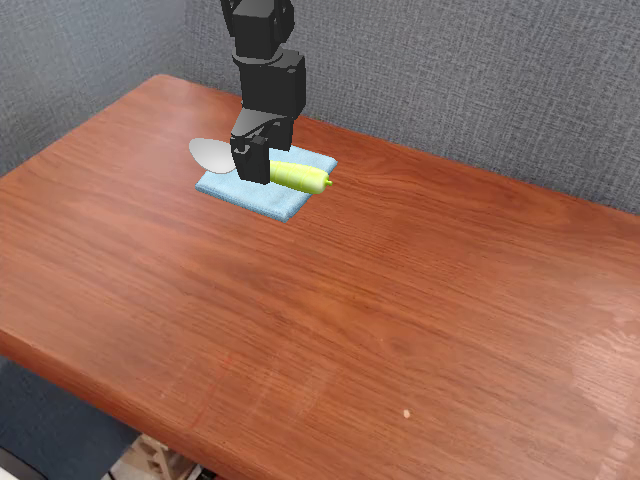

In [9]:
n = 33

print(spoon_on_table_file_one_episode["success_proc_0_numid_19_epsid_20.npz"][f"{n}_frame"]["data"])
spoon_on_table_file_one_episode["success_proc_0_numid_19_epsid_20.npz"][f"{n}_frame"]["image"]

### Zero-shot model evaluation

In [4]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(model_id)

model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager", 
).to(DEVICE)

delete model
delete processor


Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 9351.85it/s]
/home/anton/miniconda3/lib/python3.13/site-packages/transformers/models/auto/modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


In [ ]:
questions_list = [
    "What objects are in the scene?",
    "What objects do you see in the picture? Write it as a list.",
    "Is there a dinosaur in the image?",
    "Where is objects relative to each other?", 
    "Is the carrot on the plate?",
    "Is the gripper holding an object?",
    "Is there an object that can be eaten?",
    "Is the carrot on the plate? Yes/No.",
    "Is the orange object (carrot) on the yellow plate in this image? Yes/No.",
    "Is the orange object on the yellow object in this image? Yes/No.", 
]

collect_answers(carrot_on_plate_files, questions_list, model=model, processor=processor)

with open('carrot_on_plate_FML.pkl', 'wb') as f: #First Mid Last
    pickle.dump(carrot_on_plate_files, f)

collect_answers_general(carrot_on_plate_file_one_episode, questions_list, model=model, processor=processor)

with open('carrot_on_plate_one_episode.pkl', 'wb') as f: 
    pickle.dump(carrot_on_plate_file_one_episode, f)

questions_list = [
    "What objects do you see in the picture? Write it as a list.",
    "Is there a dinosaur in the image?",
    "What objects are in the scene?",
    "Where is objects relative to each other?", 
    "Is the spoon on the clothin? Yes/No.",
    "Is the gripper holding an object?",
    "Is there an object that can be eaten?",
    "Is the green/yellow object (spoon) on the blue clothin in this image? Yes/No.",
    "Is the green/yellow object on the blue object in this image? Yes/No.",
]

collect_answers(spoon_on_table_clothin_files, questions_list, model=model, processor=processor)

with open('spoon_on_table_clothin_files_FML.pkl', 'wb') as f: 
    pickle.dump(spoon_on_table_clothin_files, f)

collect_answers_general(spoon_on_table_file_one_episode, questions_list, model=model, processor=processor)

with open('spoon_on_table_file_one_episode.pkl', 'wb') as f: 
    pickle.dump(spoon_on_table_file_one_episode, f)

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [25:13, 75.66s/it]
collecting data from 1/1 file: success_proc_0_numid_70_epsid_70.npz: : 1it [14:22, 862.20s/it]
collecting data from 10/10 file: success_proc_0_numid_16_epsid_17.npz: : 10it [10:59, 65.98s/it]
collecting data from 1/1 file: success_proc_0_numid_19_epsid_20.npz: : 1it [12:26, 746.40s/it]


In [6]:
with open('carrot_on_plate_FML.pkl', 'rb') as f: #First Mid Last
    carrot_on_plate_files = pickle.load(f)

with open('carrot_on_plate_one_episode.pkl', 'rb') as f: 
    carrot_on_plate_file_one_episode = pickle.load(f)

with open('spoon_on_table_file_one_episode.pkl', 'rb') as f: 
    spoon_on_table_file_one_episode = pickle.load(f)

with open('spoon_on_table_clothin_files_FML.pkl', 'rb') as f: 
    spoon_on_table_clothin_files = pickle.load(f)

In [ ]:
carrot_on_plate_files

#### Let's first look at the general questions and evaluate the extent to which the model can perceive semantic connections

In [15]:
counter = 0
carrot_counter = 0
for _, item in carrot_on_plate_files.items():
    counter+=2
    print(item["last_iter_QA"]["Is there an object that can be eaten?"])
    if item["last_iter_QA"]["Is there an object that can be eaten?"].find("carrot") != -1:
        carrot_counter+=1
    print(item["first_iter_QA"]["Is there an object that can be eaten?"])
    if item["first_iter_QA"]["Is there an object that can be eaten?"].find("carrot") != -1:
        carrot_counter+=1

Yes, there is a food item on the table.
Yes, there is a carrot on the plate.
Yes, there is a carrot on the table.
Yes, there is a carrot and a green vegetable on the table.
Yes, there is a carrot in the image.
Yes, there is a carrot in the image.
Yes, there is a fruit in the image.
Yes, there is a carrot in the image.
Yes, there is a food item on the table.
Yes, there is a carrot and a green vegetable on the table.
Yes, there is a carrot and an orange on the table.
Yes, there is a carrot on the table.
Yes, there is a carrot on the table.
Yes, there is a carrot and a vegetable in the image.
Yes, there is a carrot on the table.
Yes, there is a carrot on the table.
Yes, there is a food item in the image.
Yes, there is a carrot on the table.
Yes, there is a fruit on the table.
Yes, there is a carrot in the image.
Yes, there is a carrot on the table.
Yes, there is a carrot and a green vegetable on the table.
Yes, there is an orange in the image.
Yes, there is a carrot on the table.
Yes, the

As you can see, the model understands that there is an edible object in the image, but it doesn't always recognize the object as a carrot. The model also sometimes perceives the carrot leaves as separate objects.

In [16]:
print(float(carrot_counter/counter))

0.75


In [10]:
for _, item in carrot_on_plate_files.items():
    print(item["last_iter_QA"]["What objects do you see in the picture? Write it as a list."])
    print(item["first_iter_QA"]["What objects do you see in the picture? Write it as a list."])
    

Computer.
1.
Carrot, table.
1.
Animal toy, table.
1 carrot and 1 orange plate.
1. There is an orange on a plate.
1.
1. There is a table in the picture.
1.
1. There is a table in the picture.
1. Carrot.
Answer: carrot, glass.
1 plate, 1 carrot, 1 leg of a chair.
There is a carrot, a lego, and a gun.
1. There is a table. On the table, there is a plate, a carrot, and a fork.
1.
1.
Answer: table.
1.
1. There is a table in the picture.
2. There is a chair on the table.
3. There is a chair on the right side of the table.
4. There is a chair on the left side of the table.
1.
There is a table, an orange, a carrot, and a gun.
1.
1. There is a table in the picture. 2. There is an orange on the table. 3. There is a wooden plank on the table. 4. There is a black and grey musical instrument on the table. 5. There is a yellow object on the wooden plank. 6. There is a wooden chair in the background. 7. There is a grey wall in the background.
1.
There are two objects in the picture: a table and a toy.

In [11]:
for _, item in carrot_on_plate_files.items():
    print(item["last_iter_QA"]["Is there a dinosaur in the image?"])
    print(item["first_iter_QA"]["Is there a dinosaur in the image?"])

No, there is no dinosaur present in the image.
No, there is no dinosaur present in the image.
There is no dinosaur present in the image.
No, there is no dinosaur present in the image.
No, there is no dinosaur present in the image.
No, there is no dinosaur present in the image.
No, there is no dinosaur present in the image.
No, there is no dinosaur present in the image.
No, there is no dinosaur present in the image.
No, there is no dinosaur present in the image.
No, there is no dinosaur present in the image.
No, there is no dinosaur present in the image.
No, there is no dinosaur present in the image.
No, there is no dinosaur present in the image.
There is no mention of a dinosaur in the image, so we cannot determine if one is present.
No, there is no dinosaur present in the image.
No, there is no dinosaur present in the image.
No, there is no dinosaur present in the image.
No, there is no dinosaur present in the image.
No, there is no dinosaur present in the image.
No, there is no dinos

In [20]:
for _, item in spoon_on_table_clothin_files.items():
    print(item["last_iter_QA"]["What objects do you see in the picture? Write it as a list."])
    print(item["first_iter_QA"]["What objects do you see in the picture? Write it as a list."])

Table.
1 table and 1 banana.
Lego.
1. table.
There are two cameras on a wooden table.
2 objects.
Camera.
1. table.
1. A wooden table. 2. A blue piece of fabric. 3. A black and gray robotic arm. 4. A yellow object.
2 objects.
Banana and pizza.
3.
1. table.
2 objects.
Lego.
1. table.
1. Table.
1. table. cucumber.
Lego.
1. table.


In [ ]:
counter = 0
carrot_counter = 0
for _, item in carrot_on_plate_files.items():
    counter+=2
    print(item["last_iter_QA"]["What objects are in the scene?"])
    if item["last_iter_QA"]["What objects are in the scene?"].find("carrot") != -1:
        carrot_counter+=1
    print(item["first_iter_QA"]["What objects are in the scene?"])
    if item["first_iter_QA"]["What objects are in the scene?"].find("carrot") != -1:
        carrot_counter+=1

There is a table in the image.
There is a plate, a carrot, and a wooden table in the image.
There is a table in the image.
There is a table in the image.
There is a table in the image.
There is a plate, a carrot, a wooden table, and a wooden wall in the image.
There is a table in the image.
There is a plate, a carrot, a fork, and a knife in the image.
There is a table in the image.
There is a carrot, a plate, and a fork in the image.
There is a table in the image.
There is a plate, a carrot, and a food item in the image.
There is a carrot, a knife, and a glass in the image.
There is a plate, a carrot, and a food item on the table in the image.
There is a table in the image.
There is a plate, a carrot, and a stove in the image.
There are toys in the image.
There is a plate, a carrot, a wooden table, and a black object in the image.
There is a table in the image.
There is a plate, a carrot, a fork, and a fork stand in the image.
There is a table in the image.
There is a plate, a carrot, 

In [14]:
print(float(carrot_counter/counter))

0.475


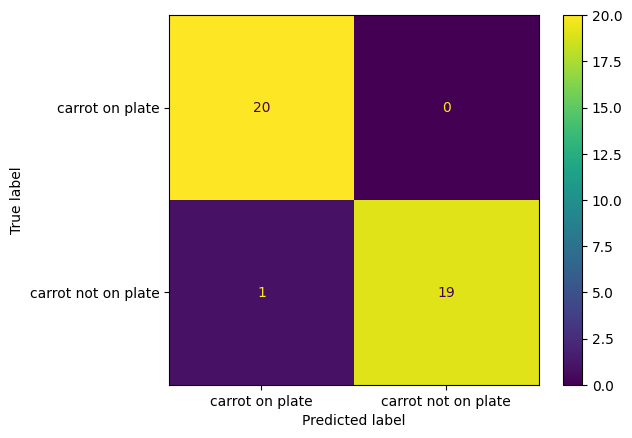

In [51]:
question = "Is the gripper holding an object?"
Pos_l = "carrot on plate"
Neg_l = "carrot not on plate"
targets = [Pos_l, Neg_l]*20
mark = "yes"

display_confusion_matrix_FL(carrot_on_plate_files, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, targets=targets)

The model also understands when a carrot is clamped in the grip of the manipulator.

### Question - Carrot on plate

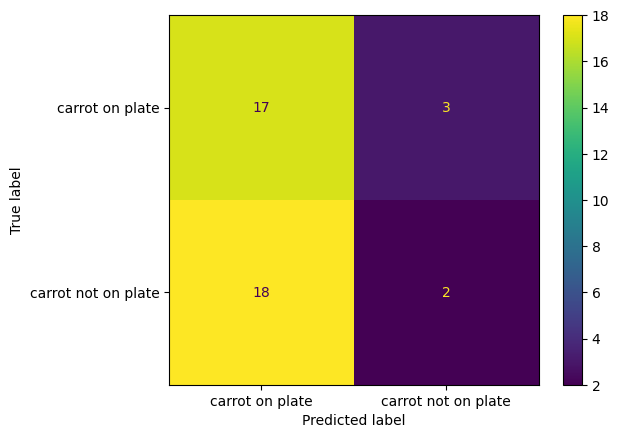

In [43]:
question = "Is the carrot on the plate?"
Pos_l = "carrot on plate"
Neg_l = "carrot not on plate"
targets = [Pos_l, Neg_l]*20
mark = "yes"

display_confusion_matrix_FL(carrot_on_plate_files, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, targets=targets)

In [ ]:
question = ["Is the carrot on the plate? Yes/No."]

collect_answers(carrot_on_plate_files, question, model=model, processor=processor)

0it [00:00, ?it/s]

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [03:26, 10.31s/it]


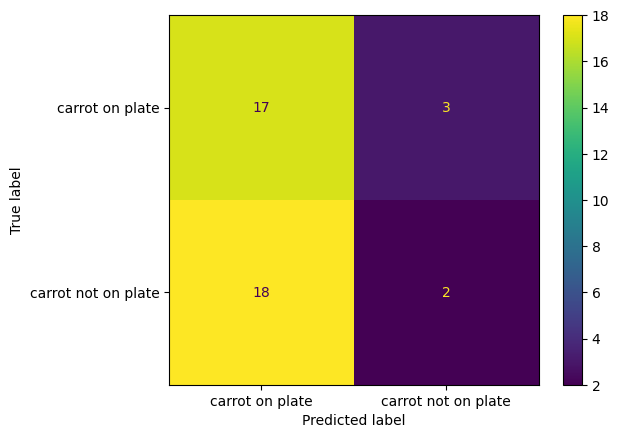

In [42]:
question = "Is the carrot on the plate? Yes/No."
Pos_l = "carrot on plate"
Neg_l = "carrot not on plate"
targets = [Pos_l, Neg_l]*20
mark = "yes"

display_confusion_matrix_FL(carrot_on_plate_files, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, targets=targets)

#### As you can see, the original model almost always thinks the carrot is on the plate. This is probably because it generalizes between the plate and the table. Let's try to improve the metrics by rephrasing the question.

In [ ]:
question = ["Is the orange object (carrot) on the yellow plate in this image? Yes/No."]

collect_answers(carrot_on_plate_files, question, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [02:35,  7.80s/it]


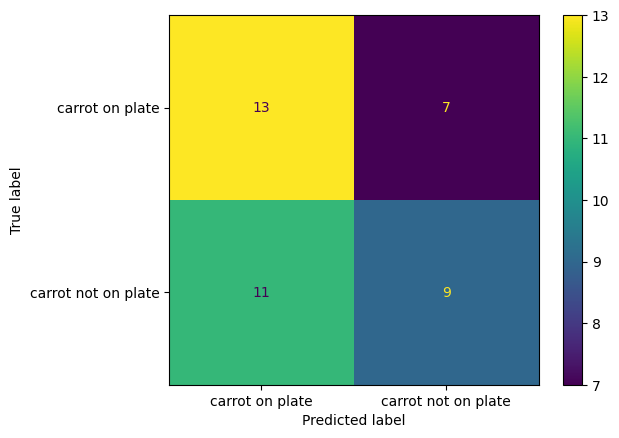

In [41]:
question = "Is the orange object (carrot) on the yellow plate in this image? Yes/No."
Pos_l = "carrot on plate"
Neg_l = "carrot not on plate"
targets = [Pos_l, Neg_l]*20
mark = "yes"

display_confusion_matrix_FL(carrot_on_plate_files, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, targets=targets)

The performance has improved. There's a suspicion that the original VLM relies more heavily on the color representation of an object than on its general name.

In [16]:
question = ["Is the orange object on the yellow object in this image? Yes/No."]

collect_answers(carrot_on_plate_files, question, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_46_epsid_46.npz: : 20it [02:34,  7.73s/it]


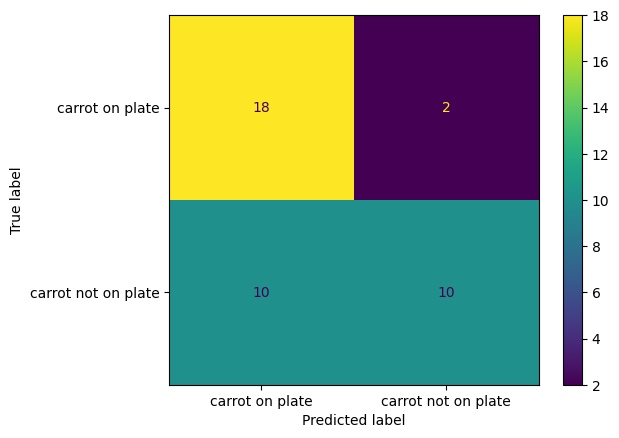

In [40]:
question = "Is the orange object on the yellow object in this image? Yes/No."
Pos_l = "carrot on plate"
Neg_l = "carrot not on plate"
targets = [Pos_l, Neg_l]*20
mark = "yes"

display_confusion_matrix_FL(carrot_on_plate_files, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, targets=targets)

We conclude that for a pre-trained model, it is more appropriate to ask about the relationship between objects based on their color, rather than their actual names.

##### Let's see how the model performs in one episode.

In [84]:
question = ["Is the carrot on the plate?"]

collect_answers_general(carrot_on_plate_file_one_episode, question, model=model, processor=processor)

collecting data from 1/1 file: success_proc_0_numid_70_epsid_70.npz: : 1it [01:43, 103.02s/it]


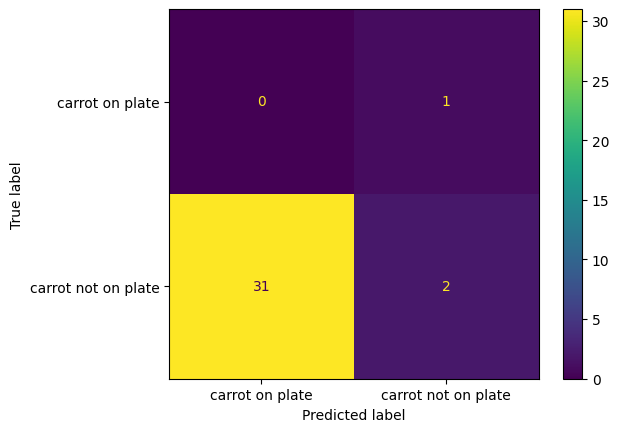

In [39]:
question = "Is the carrot on the plate?"
Pos_l = "carrot on plate"
Neg_l = "carrot not on plate"
gt_answer = "src_on_target"
mark = "yes"

display_confusion_matrix_general(carrot_on_plate_file_one_episode, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, gt_answer=gt_answer)

Text(0.5, 1.0, 'Yes, the carrot is on the plate.')

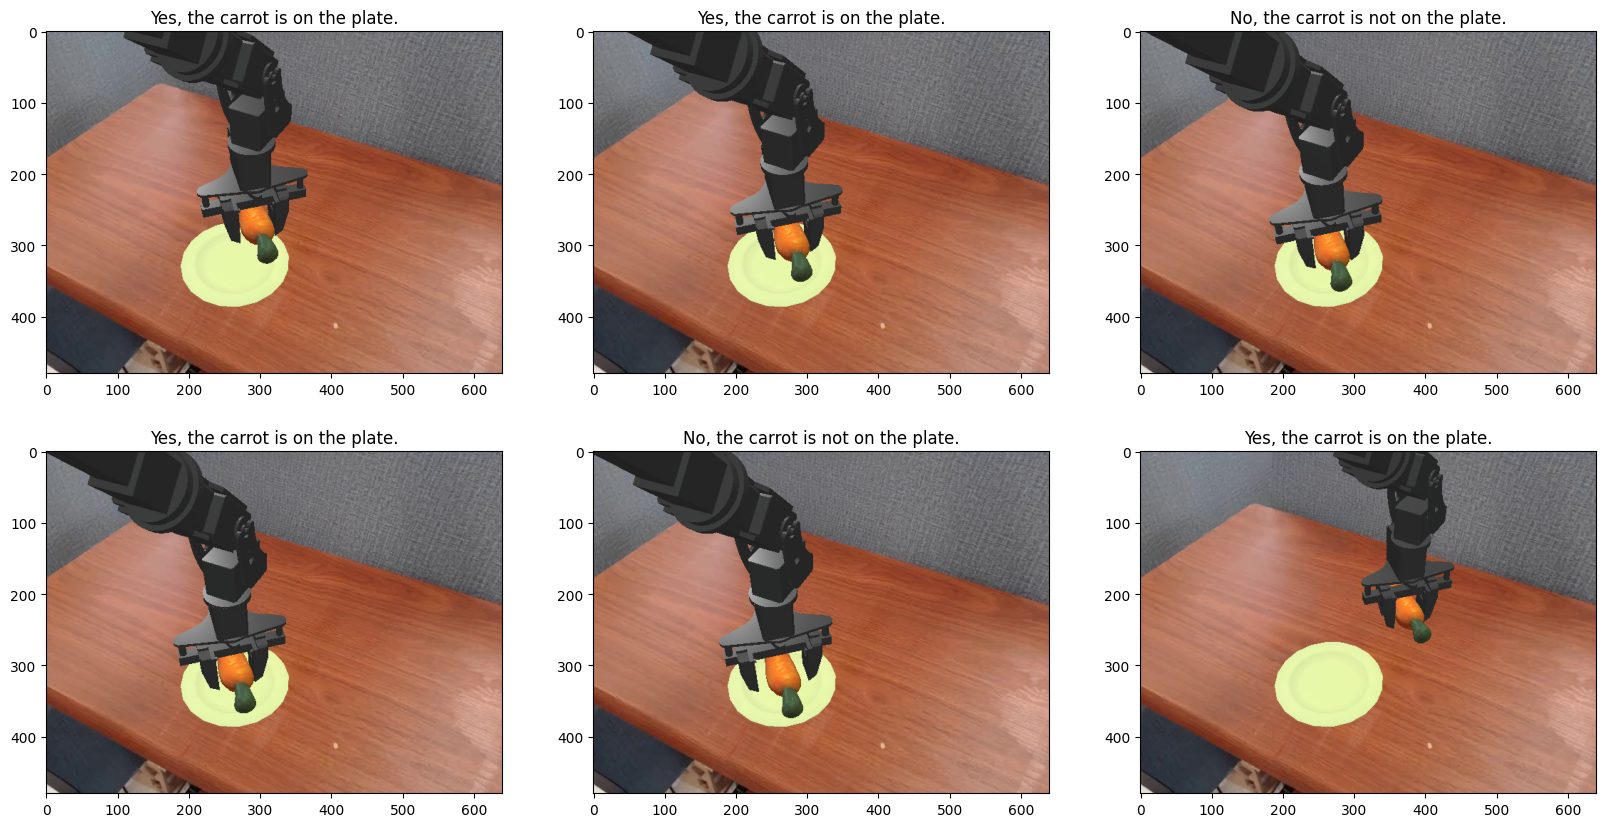

In [86]:
n = 33
fig = plt.figure(figsize=(20, 10))
for i in range(5):
    sub = fig.add_subplot(2, 3, i+1)
    sub.imshow(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{29+i}_frame"]["image"])
    sub.set_title(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{29+i}_frame"]["QA"]["Is the carrot on the plate?"])

sub = fig.add_subplot(2, 3, 6)
sub.imshow(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{18}_frame"]["image"])
sub.set_title(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{18}_frame"]["QA"]["Is the carrot on the plate?"])

### Question - spoon on clothin

In [ ]:
question = [
    "Is the spoon on the clothin? Yes/No.",
    "Is the green/yellow object (spoon) on the blue clothin in this image? Yes/No.",
    "Is the green/yellow object on the blue object in this image? Yes/No."
            ]

collect_answers(spoon_on_table_clothin_files, question, model=model, processor=processor)

collecting data from 10/10 file: success_proc_0_numid_16_epsid_17.npz: : 10it [01:18,  7.89s/it]


['spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin'] ['spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin']


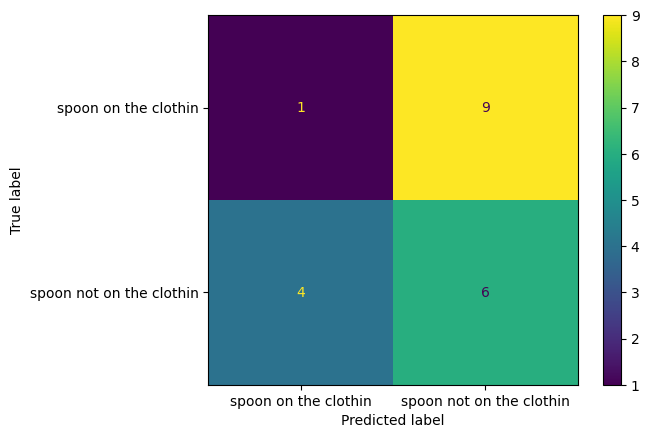

In [ ]:
question = "Is the spoon on the clothin? Yes/No."
Pos_l = "spoon on the clothin"
Neg_l = "spoon not on the clothin"
targets = [Pos_l, Neg_l]*10
mark = "yes"

display_confusion_matrix_FL(spoon_on_table_clothin_files, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, targets=targets)

['spoon not on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon on the clothin'] ['spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin']


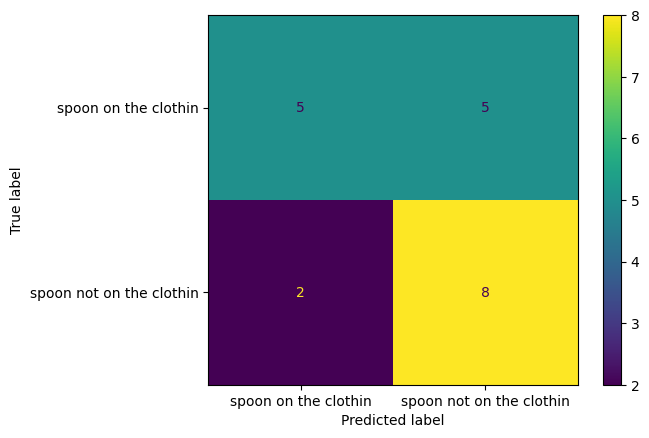

In [ ]:
question = "Is the green/yellow object (spoon) on the blue clothin in this image? Yes/No."
Pos_l = "spoon on the clothin"
Neg_l = "spoon not on the clothin"
targets = [Pos_l, Neg_l]*10
mark = "yes"

display_confusion_matrix_FL(spoon_on_table_clothin_files, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, targets=targets)

['spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin'] ['spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin']


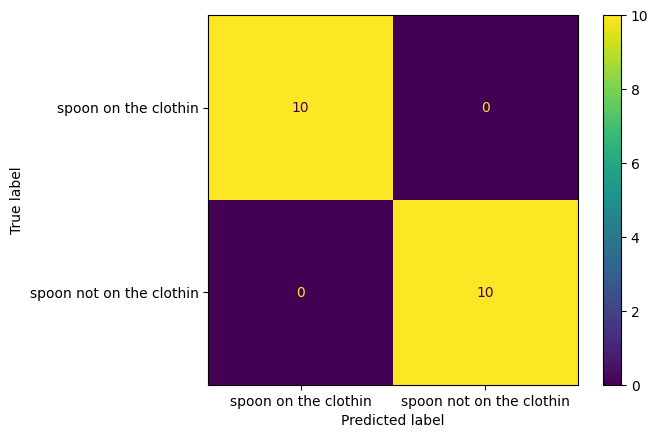

In [ ]:
question = "Is the green/yellow object on the blue object in this image? Yes/No."
Pos_l = "spoon on the clothin"
Neg_l = "spoon not on the clothin"
targets = [Pos_l, Neg_l]*20
mark = "yes"

display_confusion_matrix_FL(spoon_on_table_clothin_files, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, targets=targets)

#### As we can see from the obtained data, the hypothesis about color recognition of objects has been confirmed once again.

## SFT Train

### Make dataset

In [11]:
questions = [
    "Is the carrot on the plate?",
    "Is the carrot placed on the plate?",
    "Has the carrot been put on the plate?",
]
qa_dataset_file = build_jsonl_from_first_and_last_SFT(carrot_on_plate_files, questions, "src_on_target", "carrot_on_the_plate_dataset.jsonl")

Saved 120 samples to carrot_on_the_plate_dataset.jsonl


In [58]:
build_jsonl_from_general_data(carrot_on_plate_file_one_episode, output_file="carrot_on_plate_one_episode.jsonl")

Saved 34 samples to carrot_on_plate_one_episode.jsonl


'carrot_on_plate_one_episode.jsonl'

In [14]:
df = pd.read_json("carrot_on_the_plate_dataset.jsonl", lines=True)

df.to_json("train.jsonl", orient="records", lines=True)

dataset = load_dataset(
    "json",
    data_files={"train": "train.jsonl"}
)

Generating train split: 120 examples [00:00, 3659.69 examples/s]


### Model train

In [ ]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(model_id)

lora_config = LoraConfig(
    r=16,             
    lora_alpha=16,    
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],  
    lora_dropout=0.1,
    use_dora = True,
    init_lora_weights="gaussian",
)

model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager", 
).to(DEVICE)

model.add_adapter(lora_config)
model.enable_adapters()
peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

In [ ]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]

def collate_fn(examples):
  texts = []
  images = []
  for example in examples:
      image = Image.open(example["image"]).convert("RGB")
      question = example["question"]
      answer = example["answer"]
      messages = [
          {
              "role": "user",
              "content": [
                  {"type": "image"},
                  {"type": "text", "text": question}
              ]
          },
          {
              "role": "assistant",
              "content": [
                  {"type": "text", "text": answer}
              ]
          }
      ]
      text = processor.apply_chat_template(messages, add_generation_prompt=False)
      texts.append(text.strip())
      images.append([image])

  batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
  labels = batch["input_ids"].clone()
  labels[labels == processor.tokenizer.pad_token_id] = -100
  labels[labels == image_token_id] = -100
  batch["labels"] = labels

  return batch

In [ ]:
model_name = model_id.split("/")[-1]

training_args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=15,
    save_strategy="steps",
    save_steps=250,
    save_total_limit=1,
    optim="paged_adamw_8bit", 
    bf16=True, 
    output_dir=f"./{model_name}-carrots-and-plates",
    remove_unused_columns=False,
    gradient_checkpointing=True,

    report_to=[],
    push_to_hub=False,
    hub_model_id=None
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset["train"],
    processing_class=processor,
)

trainer.train()

### Model evaluation

Make test data:

``` bash
conda activate rlvla_env
cd RL4VLA/ManiSkill
cuda=0

CUDA_VISIBLE_DEVICES=$cuda \
python -m mani_skill.examples.motionplanning.widowx.collect_simpler \
  -e "PutOnPlateInScene25Single-v1" \
  --save_video --save_data --num_procs 1 --num_traj 20 --seed=1

```

In [39]:
carrot_on_plate_files_test = load_data_from_npz("./RL4VLA/ManiSkill/mp_collect/PutOnPlateInScene25Single-v1/20/data")

with open("carrot_on_plate_files_test_FML.pkl", "wb") as f:
    pickle.dump(carrot_on_plate_files_test, f)

In [28]:
with open('carrot_on_plate_files_test_FML.pkl', 'rb') as f: #First Mid Last
    carrot_on_plate_files_test = pickle.load(f)

In [29]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

fit_model_id = "MrAnton/smolvlm-sft-carrots" 

base_model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(base_model_id)

model = AutoModelForVision2Seq.from_pretrained(
    fit_model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager"
).to(DEVICE)


delete model
delete processor


Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 11650.84it/s]


#### Question - Carrot on plate

In [ ]:
questions = [
    "Is the carrot on the plate?",
    "Is the orange object on the yellow object in this image?",
    ]

collect_answers(carrot_on_plate_files_test, question, model=model, processor=processor)

0it [00:00, ?it/s]

collecting data from 20/20 file: success_proc_0_numid_5_epsid_5.npz: : 20it [03:28, 10.45s/it]  


['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate']


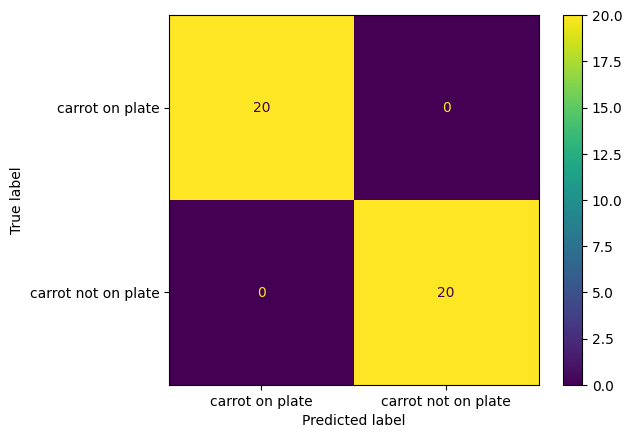

In [ ]:
question = "Is the carrot on the plate?"
Pos_l = "carrot on plate"
Neg_l = "carrot not on plate"
targets = [Pos_l, Neg_l]*20
mark = "yes"

display_confusion_matrix_FL(carrot_on_plate_files_test, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, targets=targets)

['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate']


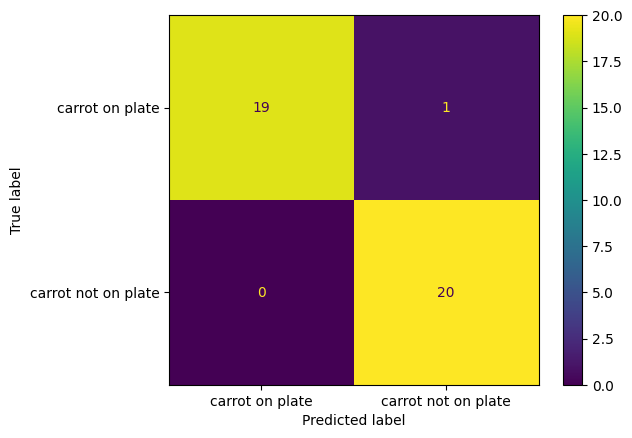

: 

In [ ]:
question = "Is the orange object on the yellow object in this image?"
Pos_l = "carrot on plate"
Neg_l = "carrot not on plate"
targets = [Pos_l, Neg_l]*20
mark = "yes"

display_confusion_matrix_FL(carrot_on_plate_files_test, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, targets=targets)

This suggests that fine-tuning the model has not been revealed in any way on the "Color perception" of objects, and even reinforce it.

In [25]:
question = ["Is the carrot on the plate?"]

collect_answers_general(carrot_on_plate_file_one_episode, question, model=model, processor=processor)

collecting data from 1/1 file: success_proc_0_numid_70_epsid_70.npz: : 1it [01:50, 110.69s/it]


['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot no

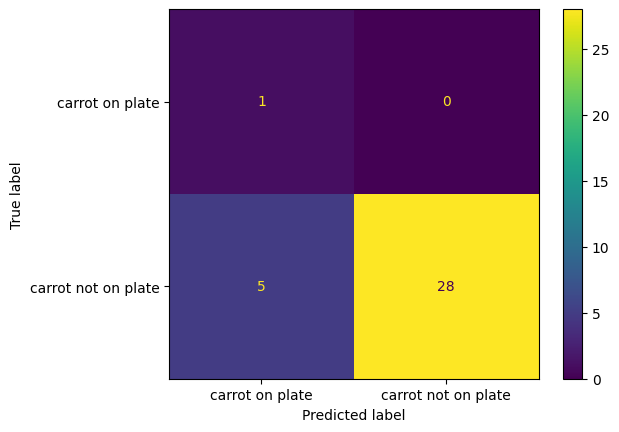

In [ ]:
question = "Is the carrot on the plate?"
Pos_l = "carrot on plate"
Neg_l = "carrot not on plate"
gt_answer = "src_on_target"
mark = "yes"

display_confusion_matrix_general(carrot_on_plate_file_one_episode, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, gt_answer=gt_answer)

##### The model worked very well, but in this case, the last 6 pictures represent the intersection of the plate and the carrot, so the model thinks that the carrot is already on the plate.

In [28]:
for pred in preds:
    print(pred)

carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot not on plate
carrot on plate
carrot on plate
carrot on plate
carrot on plate
carrot on plate


Text(0.5, 1.0, 'yes')

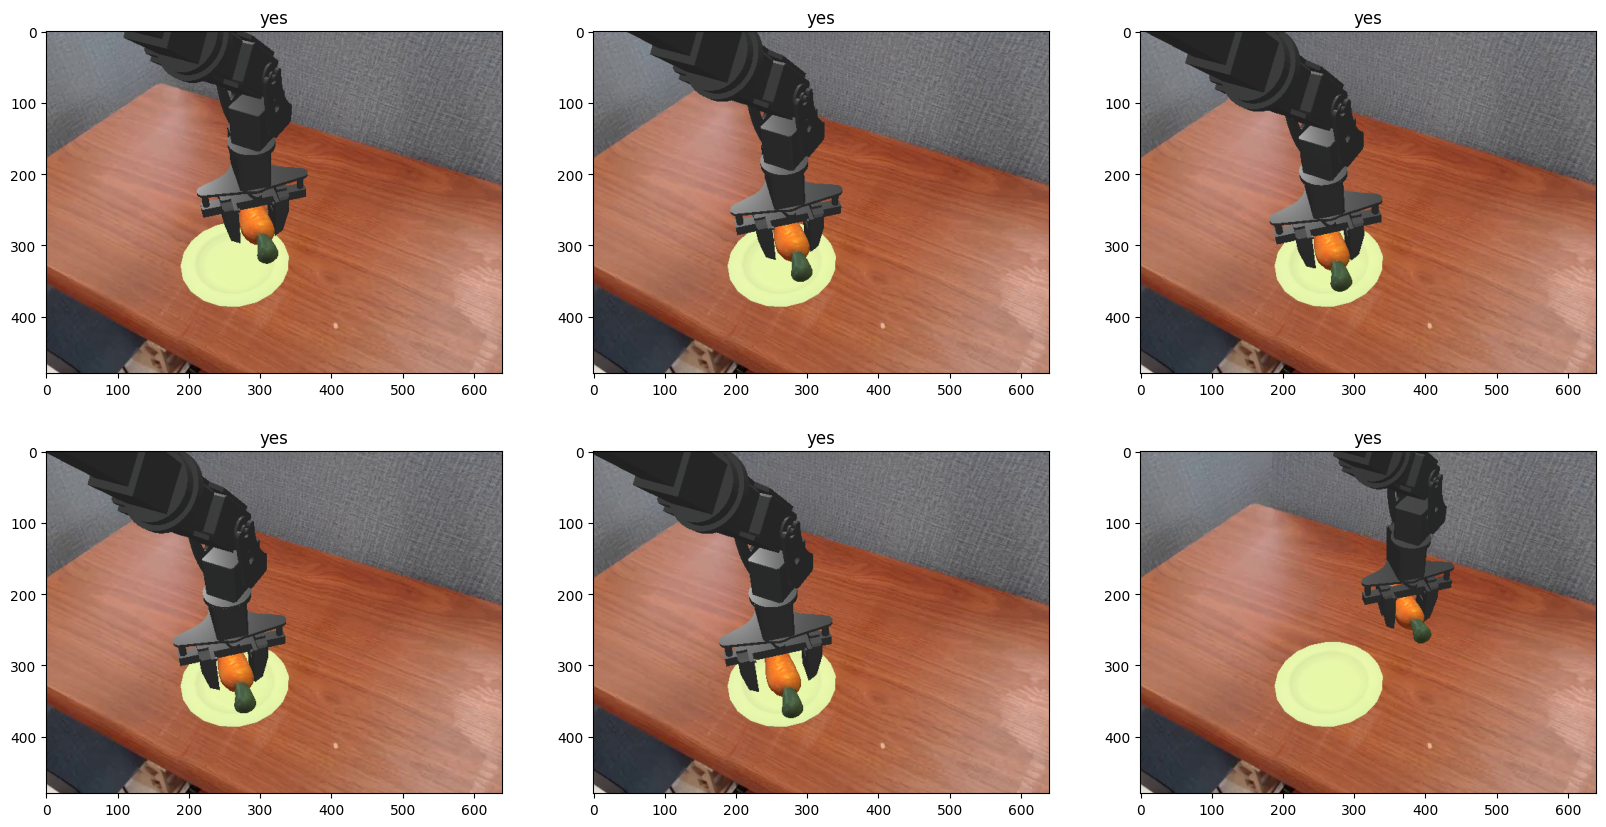

In [34]:
n = 33
fig = plt.figure(figsize=(20, 10))
for i in range(5):
    sub = fig.add_subplot(2, 3, i+1)
    sub.imshow(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{29+i}_frame"]["image"])
    sub.set_title(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{29+i}_frame"]["QA"]["Is the carrot on the plate?"])

sub = fig.add_subplot(2, 3, 6)
sub.imshow(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{18}_frame"]["image"])
sub.set_title(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{18}_frame"]["QA"]["Is the carrot on the plate?"])

In [ ]:
question = [
    "Is there an object that can be eaten?",
    "Is there an object that can be eaten? If yes, what is it?",
    ]

collect_answers_general(carrot_on_plate_file_one_episode, question, model=model, processor=processor)

collecting data from 1/1 file: success_proc_0_numid_70_epsid_70.npz: : 1it [01:52, 112.09s/it]


In [ ]:
for _, item in carrot_on_plate_file_one_episode.items():
    for i in range(len(item)):
        print(item[f"{i}_frame"]["QA"]["Is there an object that can be eaten?"])

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [8]:
for _, item in carrot_on_plate_file_one_episode.items():
    for i in range(len(item)):
        print(item[f"{i}_frame"]["QA"]["Is there an object that can be eaten? If yes, what is it?"])

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


Since all the data for the SFT contained only one token, it responded with only one token. To avoid this, a special system prompt should have been used, which will be demonstrated in the GRPO section.

The evaluation proves that the model now more or less understands what a carrot is and when it is on a plate.

### Question - spoon on clothin

In [43]:
question = ["Is the spoon on the clothin?"]

collect_answers(spoon_on_table_clothin_files, question, model=model, processor=processor)

collecting data from 10/10 file: success_proc_0_numid_16_epsid_17.npz: : 10it [01:40, 10.01s/it]


['spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon on the clothin'] ['spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin']


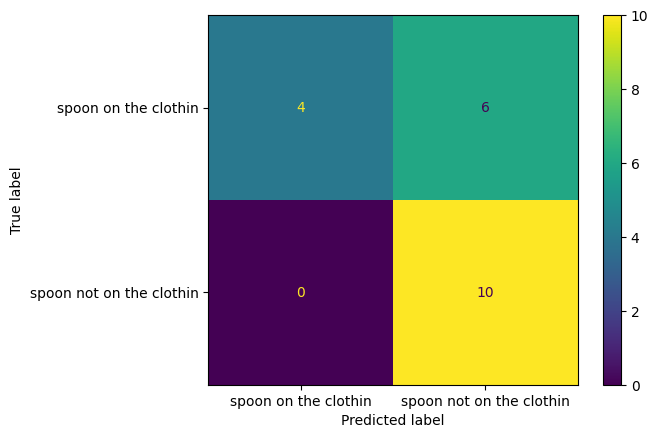

In [ ]:
question = "Is the spoon on the clothin?"
Pos_l = "spoon on the clothin"
Neg_l = "spoon not on the clothin"
targets = [Pos_l, Neg_l]*10
mark = "yes"

display_confusion_matrix_FL(spoon_on_table_clothin_files, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, targets=targets)

In [26]:
preds

['spoon not on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin']

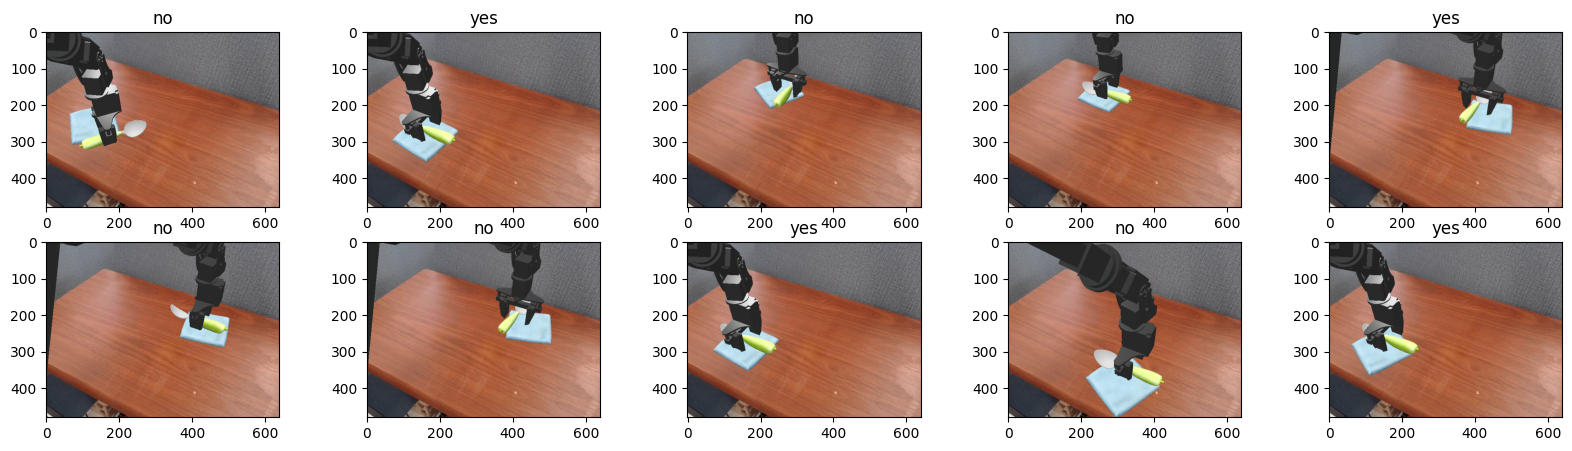

In [31]:
fig = plt.figure(figsize=(20, 5))
for i, (_, item) in enumerate(spoon_on_table_clothin_files.items()):
    sub = fig.add_subplot(2, 5, i+1)
    sub.imshow(item["last_iter"]["image"])
    sub.set_title(item["last_iter_QA"]["Is the spoon on the clothin?"])

In [38]:
question = [
    "Is the green/yellow object on the blue object in this image?"
            ]

collect_answers(spoon_on_table_clothin_files, question, model=model, processor=processor)

collecting data from 10/10 file: success_proc_0_numid_16_epsid_17.npz: : 10it [01:38,  9.81s/it]


['spoon not on the clothin', 'spoon on the clothin', 'spoon not on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin', 'spoon on the clothin'] ['spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin', 'spoon not on the clothin']


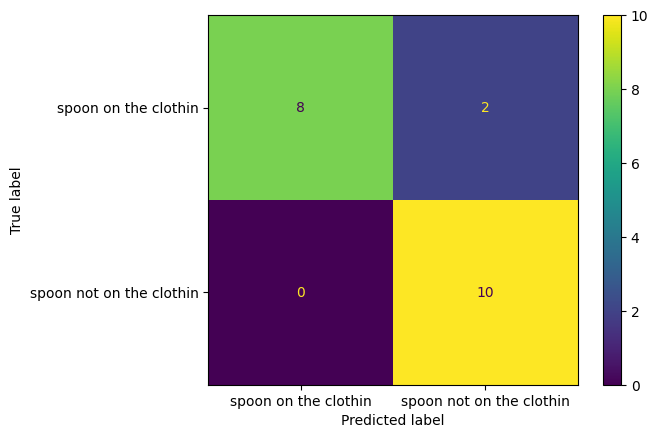

In [ ]:
question = "Is the green/yellow object on the blue object in this image?"
Pos_l = "spoon on the clothin"
Neg_l = "spoon not on the clothin"
targets = [Pos_l, Neg_l]*10
mark = "yes"

display_confusion_matrix_FL(spoon_on_table_clothin_files, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, targets=targets)

In [40]:
preds

['spoon not on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon on the clothin',
 'spoon on the clothin',
 'spoon on the clothin',
 'spoon on the clothin',
 'spoon on the clothin',
 'spoon on the clothin',
 'spoon on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin',
 'spoon not on the clothin']

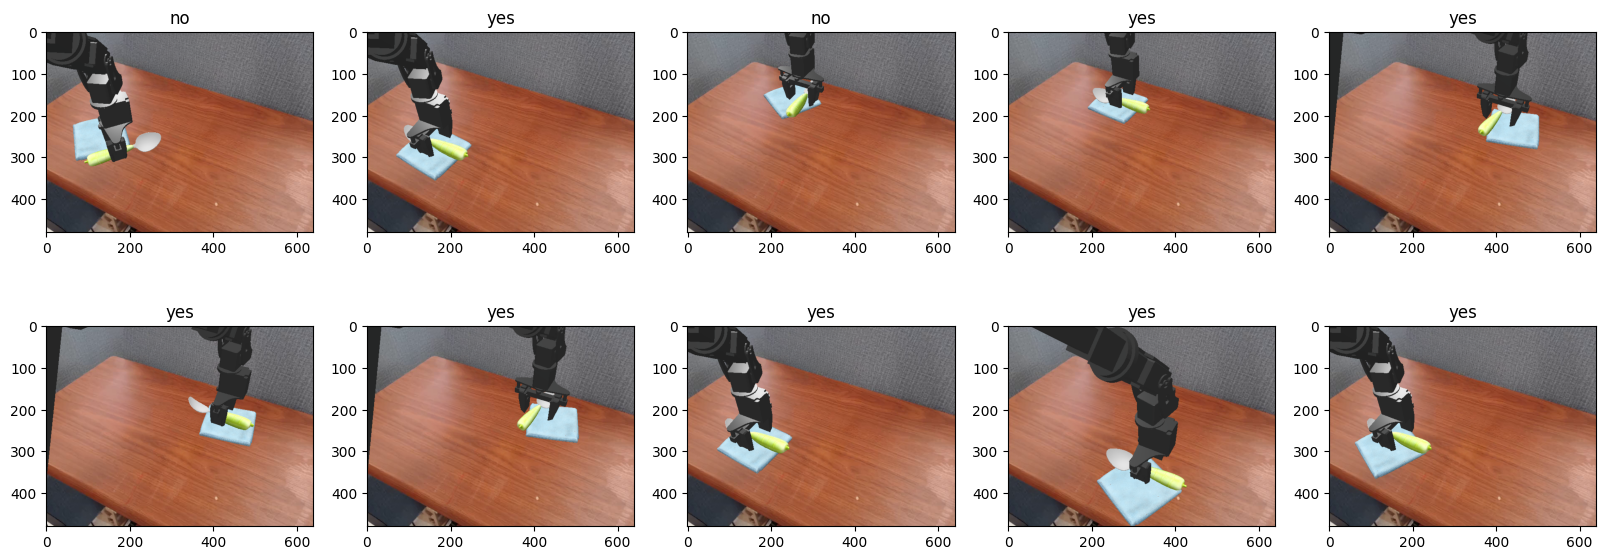

In [42]:
fig = plt.figure(figsize=(20, 7))
for i, (_, item) in enumerate(spoon_on_table_clothin_files.items()):
    sub = fig.add_subplot(2, 5, i+1)
    sub.imshow(item["last_iter"]["image"])
    sub.set_title(item["last_iter_QA"]["Is the green/yellow object on the blue object in this image?"])

We can see that fine-tuning the model did not have much of harmful to the spoon-clothin task.

## Inference Octo-small

```bash
conda activate octo_env
cd RL4VLA/SimplerEnv
cuda=0

CUDA_VISIBLE_DEVICES=$cuda XLA_PYTHON_CLIENT_PREALLOCATE=false \
python simpler_env/eval_ms3_collect.py \
  --env_id "PutCarrotOnPlateInScene-v1"\
  --num-episodes 10 --num-envs 1 --seed 0

CUDA_VISIBLE_DEVICES=$cuda XLA_PYTHON_CLIENT_PREALLOCATE=false \
python simpler_env/eval_ms3_collect.py \
  --env_id "StackGreenCubeOnYellowCubeBakedTexInScene-v1"\
  --num-episodes 10 --num-envs 1 --seed 0

CUDA_VISIBLE_DEVICES=$cuda XLA_PYTHON_CLIENT_PREALLOCATE=false \
python simpler_env/eval_ms3_collect.py \
  --env_id "PutSpoonOnTableClothInScene-v1"\
  --num-episodes 10 --num-envs 1 --seed 0

```

## GRPO Train

### Simple task: predict on the plate/not on the plate

#### Make a dataset:

In [ ]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(model_id)

model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.float32,
    _attn_implementation="eager", 
).to(DEVICE)

SYSTEM_PROMPT = (
    "Answer strictly in the format: "
    "yes/no"
)

def make_conversation(example):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": example["question"] + SYSTEM_PROMPT},
            ],
        },
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    return {
        "prompt": prompt,
        "image": example["image"],
        "labels": example["answer"], 
    }

dataset_grpo = dataset["train"].cast_column("image", datasets.Image(decode=True))
dataset_grpo = dataset_grpo.map(make_conversation)
dataset_grpo = dataset_grpo.remove_columns(["question", "answer", "data"])

#### Reward function

In [ ]:
def crt_on_plt_reward_function(completions, **kwargs):
    rewards = []
    labels = kwargs["labels"]  # ground truth answers

    for comp, label in zip(completions, labels):
        row_rewards = -10.0
        comp_lower = comp.lower()
        if "yes" in comp_lower and label == "yes":
            row_rewards = 1.0
        elif "no" in comp_lower and label == "no":
            row_rewards = 1.0
        
        rewards.append(row_rewards)

    print("COMP LIST: ", completions)
    print("ROW REWARDS: ", rewards)
    print("LABELS LIST: ", labels)
    return rewards

#### GRPO Train

In [ ]:
cfg = GRPOConfig(
    output_dir=f"./{model_id}_grpo_carrot_plate_yesno_task",
    learning_rate=1e-5,
    remove_unused_columns=False,  
    num_train_epochs=1,
    bf16=True,
   
    per_device_train_batch_size=2,
    max_completion_length=1,  
    num_generations=2,  
    max_prompt_length=2048,

    push_to_hub=False,
    save_strategy="steps",
    save_steps=10,

    save_total_limit=1,

    report_to=[],
)

trainer = GRPOTrainer(
    model=model,
    processing_class=processor,
    reward_funcs=[crt_on_plt_reward_function],
    args=cfg,
    train_dataset=dataset_grpo,
)

trainer.train()

#### GRPO Model eval

In [60]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model_id = "MrAnton/SmolVLM-256M-Instruct_grpo_carrot_plate_yesno_task"
processor = AutoProcessor.from_pretrained(model_id)

model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager", 
).to(DEVICE)

delete model
delete processor


Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 10255.02it/s]
/home/anton/miniconda3/lib/python3.13/site-packages/transformers/models/auto/modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


In [59]:
with open('carrot_on_plate_files_test_FML.pkl', 'rb') as f: #First Mid Last
    carrot_on_plate_files_test = pickle.load(f)

In [ ]:
question_list = [
    f"Is the orange object on the yellow object in this image?{SYSTEM_PROMPT}",
    f"Is the orange object (carrot) on the yellow plate in this image?{SYSTEM_PROMPT}" ,
    f"Is the carrot on the plate?{SYSTEM_PROMPT}",
                 ]

collect_answers(carrot_on_plate_files_test, question_list, model=model, processor=processor)

In [68]:
print(question_list)

['Is the orange object on the yellow object in this image?Answer strictly in the format: yes/no', 'Is the orange object (carrot) on the yellow plate in this image?Answer strictly in the format: yes/no', 'Is the carrot on the plate?Answer strictly in the format: yes/no']


['carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot not on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate']


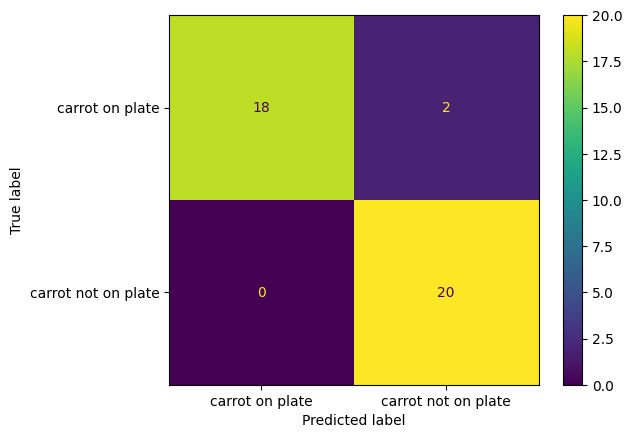

In [ ]:
question = f"Is the carrot on the plate?{SYSTEM_PROMPT}"
Pos_l = "carrot on plate"
Neg_l = "carrot not on plate"
targets = [Pos_l, Neg_l]*20
mark = "yes"

display_confusion_matrix_FL(carrot_on_plate_files_test, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, targets=targets)

### Teaching the model predict "Carrot on plate?" state and the distance between the carrot and the plate

#### Make a dataset:

In [ ]:
SYSTEM_PROMPT = (
    "Answer strictly in the format: "
    "yes/no, <number> "
    "Example: yes, 0.021 "
    "Example: no, 0.513 "
)

def make_conversation(example):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": example["question"] + SYSTEM_PROMPT},
            ],
        },
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    return {
        "prompt": prompt,
        "image": example["image"],
        "labels": example["answer"], 
        "dist_between_answer": example["data"]["carrot_plate_dist"]
    }

dataset_grpo = dataset["train"].cast_column("image", datasets.Image(decode=True))
dataset_grpo = dataset_grpo.map(make_conversation)
dataset_grpo = dataset_grpo.remove_columns(["question", "answer", "data"])

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map: 100%|██████████| 120/120 [00:01<00:00, 87.66 examples/s]


In [ ]:
print(dataset_grpo[0]["prompt"])

<|im_start|>User: Answer strictly in the format: yes/no, <number> Example: yes, 0.3 Example: no, 0 <image>Is the carrot on the plate?<end_of_utterance>
Assistant:


#### Create a warm-up model, using SFT, for teach the model predict right format (yes/no, dist):

In [ ]:
df = pd.read_json("carrot_on_the_plate_dataset.jsonl", lines=True)

df.to_json("warm_up_GRPO.jsonl", orient="records", lines=True)

dataset = load_dataset(
    "json",
    data_files={"train": "warm_up_GRPO.jsonl"}
)

Generating train split: 120 examples [00:00, 21722.77 examples/s]


In [16]:
round(dataset["train"]["data"][0]["carrot_plate_dist"][0], 3)

0.124

In [ ]:
number = "0.16"
float(number)

0.16

In [ ]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
processor = AutoProcessor.from_pretrained(model_id)

lora_config = LoraConfig(
    r=16,             
    lora_alpha=16,    
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],  
    lora_dropout=0.1,
    use_dora = True,
    init_lora_weights="gaussian",
)

model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager", 
).to(DEVICE)

model.add_adapter(lora_config)
model.enable_adapters()
peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

In [ ]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]

def collate_fn(examples):
  texts = []
  images = []
  for example in examples:
      image = Image.open(example["image"]).convert("RGB")
      question = example["question"]
      answer = example["answer"]
      dist = str(round(example["data"]["carrot_plate_dist"][0], 3))
      messages = [
          {
              "role": "user",
              "content": [
                  {"type": "image"},
                  {"type": "text", "text": question + SYSTEM_PROMPT}
              ]
          },
          {
              "role": "assistant",
              "content": [
                  {"type": "text", "text": f"{answer}, {dist}"}
              ]
          }
      ]
      text = processor.apply_chat_template(messages, add_generation_prompt=False)
      texts.append(text.strip())
      images.append([image])

  batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
  labels = batch["input_ids"].clone()
  labels[labels == processor.tokenizer.pad_token_id] = -100
  labels[labels == image_token_id] = -100
  batch["labels"] = labels

  return batch

In [ ]:
batch = collate_fn(dataset["train"])

<|im_start|>User: Answer strictly in the format: yes/no, <number> Example: yes, 0.02 Example: no, 0.51 <image>Is the carrot on the plate?<end_of_utterance>
Assistant: no, 0.12<end_of_utterance>



#### Train warm-up model

In [ ]:
model_name = model_id.split("/")[-1]

training_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,
    warmup_steps=5,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=15,
    save_strategy="steps",
    save_steps=250,
    save_total_limit=1,
    optim="paged_adamw_8bit",
    bf16=True,
    output_dir=f"./{model_name}-carrots-and-plates-GRPO-warmup",
    remove_unused_columns=False,
    gradient_checkpointing=True,

    report_to=[],
    push_to_hub=False,
    hub_model_id=None
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=grpo_warmup_dataset["train"],
    processing_class=processor,
)

trainer.train()

In [21]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

fit_model_id = "MrAnton/SmolVLM-256M-Instruct-carrots-and-plates-GRPO-warmup"

processor = AutoProcessor.from_pretrained(fit_model_id)

model = AutoModelForVision2Seq.from_pretrained(
    fit_model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager"
).to(DEVICE)

delete model
delete processor


Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 11397.57it/s]
/home/anton/miniconda3/lib/python3.13/site-packages/transformers/models/auto/modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


In [46]:
with open('carrot_on_plate_files_test_FML.pkl', 'rb') as f: #First Mid Last
    carrot_on_plate_files_test = pickle.load(f)

#### Warm-up model evaluation

In [47]:
question = [f"Is the carrot on the plate?{SYSTEM_PROMPT}"]

collect_answers(carrot_on_plate_files_test, question, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_5_epsid_5.npz: : 20it [04:45, 14.30s/it]  


In [48]:
for _, item in carrot_on_plate_files_test.items():
    print(item["first_iter_QA"][f"Is the carrot on the plate?{SYSTEM_PROMPT}"], item["first_iter"]["data"]["carrot_plate_dist"])

no, 0.102 [0.10050591]
yes, 0.027 [0.10042264]
no, 0.102 [0.12844403]
no, 0.102 [0.10118119]
no, 0.102 [0.09976418]
no, 0.102 [0.09677422]
no, 0.102 [0.16316684]
no, 0.102 [0.12243675]
no, 0.102 [0.12696698]
yes, 0.027 [0.12695055]
no, 0.102 [0.17757949]
no, 0.102 [0.16232416]
no, 0.102 [0.12772037]
no, 0.102 [0.15189087]
no, 0.102 [0.09639209]
no, 0.102 [0.13511255]
yes, 0.027 [0.09287106]
no, 0.102 [0.11054234]
no, 0.102 [0.17671199]
no, 0.102 [0.15259154]


['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate']


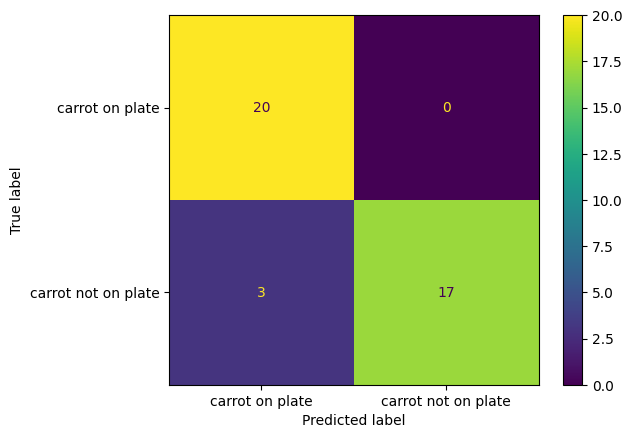

In [ ]:
question = f"Is the carrot on the plate?{SYSTEM_PROMPT}"
Pos_l = "carrot on plate"
Neg_l = "carrot not on plate"
targets = [Pos_l, Neg_l]*20
mark = "yes"

display_confusion_matrix_FL(carrot_on_plate_files_test, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, targets=targets)

In [26]:
question = [f"Is the carrot on the plate?{SYSTEM_PROMPT}"]

collect_answers_general(carrot_on_plate_file_one_episode, question, model=model, processor=processor)

collecting data from 1/1 file: success_proc_0_numid_70_epsid_70.npz: : 1it [02:32, 152.84s/it]


In [29]:
for i in range(34):
    print(carrot_on_plate_file_one_episode["success_proc_0_numid_70_epsid_70.npz"][f"{i}_frame"]["QA"][f"Is the carrot on the plate?{SYSTEM_PROMPT}"], "-----", item[f"{i}_frame"]["data"]["carrot_plate_dist"])

no, 0.102 ----- [0.1240821]
no, 0.102 ----- [0.12424913]
no, 0.102 ----- [0.1240285]
no, 0.102 ----- [0.12402793]
no, 0.102 ----- [0.12402793]
no, 0.102 ----- [0.12402793]
no, 0.102 ----- [0.12402793]
yes, 0.027 ----- [0.12420858]
no, 0.102 ----- [0.12404753]
no, 0.102 ----- [0.1242718]
no, 0.123 ----- [0.12410049]
no, 0.123 ----- [0.12389045]
no, 0.102 ----- [0.12402581]
no, 0.102 ----- [0.12392507]
no, 0.102 ----- [0.12392508]
no, 0.074 ----- [0.12392477]
yes, 0.027 ----- [0.12357179]
yes, 0.027 ----- [0.12351546]
yes, 0.027 ----- [0.12333747]
no, 0.085 ----- [0.1269331]
yes, 0.027 ----- [0.13919993]
no, 0.085 ----- [0.15303981]
yes, 0.027 ----- [0.16043192]
yes, 0.027 ----- [0.16029882]
yes, 0.027 ----- [0.15771039]
yes, 0.027 ----- [0.14900385]
yes, 0.027 ----- [0.13250741]
yes, 0.027 ----- [0.10694334]
no, 0.102 ----- [0.07745405]
yes, 0.027 ----- [0.05288869]
yes, 0.027 ----- [0.03746716]
yes, 0.027 ----- [0.03173777]
yes, 0.027 ----- [0.03142527]
yes, 0.027 ----- [0.0245743]


#### GRPO Train

In [ ]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

base_model_id = "HuggingFaceTB/SmolVLM-256M-Instruct"
model_id = "MrAnton/SmolVLM-256M-Instruct-carrots-and-plates-GRPO-warmup"

processor = AutoProcessor.from_pretrained(base_model_id, use_fast=True, padding_side='left')

lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=8,             
    lora_alpha=8,    
    target_modules=['q_proj', 'v_proj'],  
    lora_dropout=0.1,
)

model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    _attn_implementation="eager", 
).to(DEVICE)

model_peft = get_peft_model(model, lora_config)
model_peft.print_trainable_parameters()

Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 11831.61it/s]


trainable params: 755,712 || all params: 257,240,640 || trainable%: 0.2938


In [ ]:
def crt_on_plt_reward_function(completions, **kwargs):
    rewards = []
    labels = kwargs["labels"] 

    for comp, label in zip(completions, labels):
        row_rewards = 0.0
        comp_lower = comp.lower()
        if "yes" in comp_lower and label == "yes":
            row_rewards = 1.0
        elif "no" in comp_lower and label == "no":
            row_rewards = 1.0
        
        rewards.append(row_rewards)

    return rewards

def dist_between_plt_and_carrot(completions, **kwargs):
    gt_list = kwargs["dist_between_answer"]
    rewards = []

    for cand, gt in zip(completions, gt_list):
        match = re.search(r"[+]?\d*\.?\d+", str(cand))
        if match:
            pred_val = float(match.group(0))
            rewards.append(-(10*(pred_val - gt[0])**2)/(max(gt[0], 1e-6)**2))
        else:
            rewards.append(-15.0)
    
    return rewards

In [ ]:
completions = ["no, 0.1", "no, 0.6", "yes, 0.0"]

gt_list = [0.4, 0.4, 0.4]
rewards = []

for cand, gt in zip(completions, gt_list):
    match = re.search(r"[+]?\d*\.?\d+", str(cand))
    if match:
        pred_val = float(match.group(0))
        print(pred_val)
        rewards.append(-((pred_val - gt)**2)/(max(gt, 1e-6)**2))
    else:
        rewards.append(-15.0)
print(rewards)


0.1
0.6
0.0
[-0.5625, -0.24999999999999983, -1.0]


In [ ]:
cfg = GRPOConfig(
    output_dir=f"./{model_id}_grpo_simpler_task",
    learning_rate=1e-5,
    remove_unused_columns=False, 
    num_train_epochs=1,
    bf16=True,
    
    per_device_train_batch_size=2,
    max_completion_length=256, 
    num_generations=2,  
    max_prompt_length=2048,

    logging_steps=15,
    save_strategy="epoch",
    save_total_limit=1,

    report_to=[],
    push_to_hub=False,
    hub_model_id=None
)

trainer = GRPOTrainer(
    model=model,
    processing_class=processor,
    reward_funcs=[crt_on_plt_reward_function, dist_between_plt_and_carrot],
    args=cfg,
    train_dataset=dataset_grpo,
)

trainer.train()

In [76]:
clear_model_data(model=model, processor=processor)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

fit_model_id = "MrAnton/SmolVLM-256M-Instruct-carrots-and-plates-GRPO-warmup_grpo_carrot_plate_dist_task"

processor = AutoProcessor.from_pretrained(fit_model_id)

model = AutoModelForVision2Seq.from_pretrained(
    fit_model_id,
    torch_dtype=torch.float16,
    _attn_implementation="eager"
).to(DEVICE)

delete model
delete processor


Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]
/home/anton/miniconda3/lib/python3.13/site-packages/transformers/models/auto/modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


In [77]:
question = [f"Is the carrot on the plate?{SYSTEM_PROMPT}"]

collect_answers(carrot_on_plate_files_test, question, model=model, processor=processor)

collecting data from 20/20 file: success_proc_0_numid_5_epsid_5.npz: : 20it [04:35, 13.77s/it]  


In [75]:
print(question)

['Is the carrot on the plate?Answer strictly in the format: yes/no, <number> Example: yes, 0.021 Example: no, 0.513 ']


In [78]:
for _, item in carrot_on_plate_files_test.items():
    print(item["first_iter_QA"][f"Is the carrot on the plate?{SYSTEM_PROMPT}"], item["first_iter"]["data"]["carrot_plate_dist"])

no, 0.102 [0.10050591]
yes, 0.027 [0.10042264]
no, 0.102 [0.12844403]
no, 0.102 [0.10118119]
no, 0.102 [0.09976418]
no, 0.102 [0.09677422]
no, 0.102 [0.16316684]
no, 0.102 [0.12243675]
no, 0.102 [0.12696698]
yes, 0.027 [0.12695055]
no, 0.102 [0.17757949]
no, 0.102 [0.16232416]
no, 0.102 [0.12772037]
no, 0.102 [0.15189087]
no, 0.102 [0.09639209]
no, 0.102 [0.13511255]
yes, 0.027 [0.09287106]
no, 0.102 [0.11054234]
no, 0.102 [0.17671199]
no, 0.102 [0.15259154]


['carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate', 'carrot on plate'] ['carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate', 'carrot on plate', 'carrot not on plate', 'carrot not on plate', 'carrot not on plate']


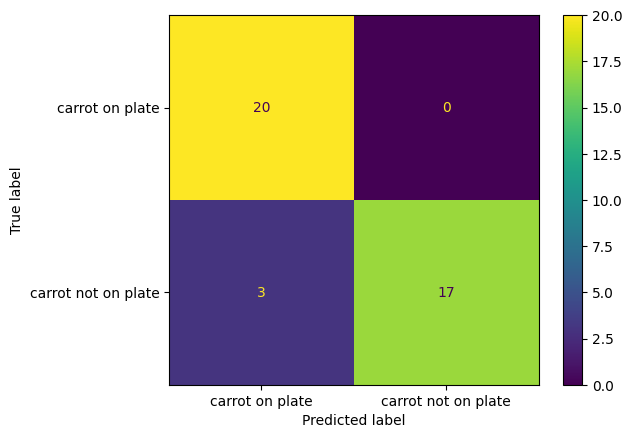

In [ ]:
question = f"Is the carrot on the plate?{SYSTEM_PROMPT}"
Pos_l = "carrot on plate"
Neg_l = "carrot not on plate"
targets = [Pos_l, Neg_l]*20
mark = "yes"

display_confusion_matrix_FL(carrot_on_plate_files_test, P=Pos_l, N=Neg_l, question=question, positive_mark=mark, targets=targets)